# Analysis of GPR

#### Author: D. Li
#### 23.3.2020

This is the analytical solution of GPR model in a 0D (point) problem. 
Analytical solutions are based on Maurizio's crack paper and GPRDI documentation.

Two key variables are:

1) shear relaxation time $\tau$

$\tau_I = \tau_{I0}\exp(\alpha_1 - \beta_1(1-\xi) Y)$

$\tau_D = \tau_{D0}\exp(\alpha_2 - \beta_2\xi Y)$


2) damage coefficient $\xi$

$\xi = (1-\xi) Ec (\xi+\xi_\epsilon)[(1-\xi)(\frac{Y}{Y_0})^a+\xi(\frac{Y}{Y_1})]$

$\tau_I, \tau_D$ are relaxation time for intact and damaged rock. Damage function $\xi$ is introduced in the given format. $Ec=\partial E/\partial \xi $. $\tau_{I0},\tau_{D0}, \alpha_1,\beta_1, \alpha_2, \beta_2, Y_1, Y_0,\xi_\epsilon, a $ are constants. This damage coefficient will result in a weakening of the materials and thus release shear stress. We assume an initial strain tensor and constant strain rate tensor in the analysis.

We further define an equivalent coefficient as the ratio between YY and P. The shape of this equivalent coefficient approximates linear slip weakening (LSW) or Rate-and-sate (RSF) as in dynamic simulation. 


In [75]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from functions import *

%matplotlib inline

In [141]:
## initialize parameters and variables in GPR model 0D
# mu1 lambda1 k mu2 lambda2 K1, K2: shear modulus, Lame's and bulk modulus
# ti te: start and ending time
# alpha1, beta1, alpha2, beta2: in the definition of shear relaxation time tau1 and tau2
# strain0 and strainR: initial strain tensor and constant strain rate tensor.
# D: fault zone thickness: in calculating V_{plastic} = 2*strainRII * D

c0 = 0.1; # initial \xi

alpha1 = 36.25; # intact rock
beta1 = 0;
tau01= 1e1;

alpha2 = 36.8; # damage rock
beta2 = 1e-2;
tau02 = 1e1;

lambda1 = 61.38e9;
lambda2 = lambda1;
rho0 = 2670;

mu1 = 30.36e9;
mu2 = 1e-4*mu1;

K1 = lambda1 + 2/3*mu1;
K2 = lambda2 + 2/3*mu2;

ce = 1e-16;
eps_f11 = 10; # inital strain magnitude.

Y1 = 0.01e9;
Y0 = 1.4e9;
a = 32.5;

t = np.linspace(0,1,1001); # time integral
YY = np.zeros(np.size(t)); # second invariant
c = np.zeros(np.size(t)); # Xi
tauM = np.zeros(np.size(t)); # tauM
P = np.zeros(np.size(t)); # hydrostatic stress
vp = np.zeros(np.size(t)); # v_{plastic}
slp = np.zeros(np.size(t)); # slip (meter)

sxy = np.zeros(np.size(t));
sxx = np.zeros(np.size(t));
syy = np.zeros(np.size(t));
rhoE = np.zeros(np.size(t));
E = np.zeros(np.size(t));
rho = np.zeros(np.size(t));
M = np.zeros(np.size(t)); # average mu
L = np.zeros(np.size(t)); # average lambda

c[0] = c0;

mu_a =  (1-c[0])*mu2+ c[0] * mu1; #% eq 57
K_a  =  (1-c[0])*K2 + c[0] * K1;  #% 

M[0] = mu1*mu2/mu_a;   # % eq. 45
L[0] = K1*K2/K_a - 2/3 *mu1* mu2 /mu_a;    
    

# constant strain rate tensor
#ee_f = np.array([eps_f11,1,1,1,1,1]);

#strainR_11,strainR_22,strainR_33,strainR_12,strainR_13,strainR_23 = TransStrain(ee_f);

strainR_11 = 1e-3;
strainR_12 = 10e-3;

strainR_33 = 0.0e-1;
strainR_22 = 0.0e-1;
strainR_13 = 5e-3;
strainR_23 = 0e-3;

strainR = np.matrix([[strainR_11,strainR_12,strainR_13],
           [strainR_12, strainR_22, strainR_23],
          [ strainR_13, strainR_23, strainR_33 ]]); 

# initial strain tensor

strain11 = 1e-8;
strain12 = 1e-8;

strain22 = -0.e-3;
strain13 = -0.e-3;
strain33 = 0.0e-11;
strain23 = 0;

strain0 = np.matrix([[strain11,strain12,strain13],
              [strain12,   strain22,   strain23],
              [strain13, strain23 ,strain33]]);

D = 1; # in meter

P.shape

# try different damage function

def GetXi2(c0,t,aa1,aa2,ti,te): # eq. 70
    if (t<ti or t> te):
        c = (c0+aa2/aa1)*np.exp(100*aa1*t) - aa2/aa1;
    else:
        c = (c0+aa2/aa1)*np.exp(100*aa1*t) - aa2/aa1;
#         Maurizio
#       dcdt = (t-ti)/(te-ti); # linear 
#        dcdt = (mu2 + (mu1-mu2)/(1+ ((t-ti)/(te-ti))^2 ) ^1/2 )/mu2;

    return c;


In [142]:
# the second part is based on 

for i in range(1,t.size):
    
    mu_a =  (1-c[i-1])*mu2 + c[i-1] * mu1; #% eq 57
    K_a  =  (1-c[i-1])*K2  +  c[i-1] * K1;  #% 

    M[i] = mu1*mu2/mu_a;   # % eq. 45
    L[i] = K1*K2/K_a - 2/3 *mu1* mu2 /mu_a;    
    
    strain = strain0 + (t[i]-t[i-1])*strainR;
    sigma,P[i] = StrainToStress(strain,L[i],M[i]);
    
    YY[i] = second(sigma);

    rhoE[i] = Get_energy(strain,rho0,L[i],M[i]);
    rho[i] = rho0*(1-strain.trace());
    E[i] = rhoE[i]/rho[i];
            
    if (i<1):
        Ec = CalcEc(rho0,K1,K2,K_a,mu1,mu2,mu_a,strain);
        c[i] = c[i-1];
    else:
        Ec = CalcEc(rho0,K1,K2,K_a,mu1,mu2,mu_a,strain);
        aa1 = -(1-c[i-1])*Ec*(c[i-1]+ce)*((1-c[i-1])*(YY[i]/Y0)**a + c[i-1]*(YY[i]/Y1))
        aa2 = aa1*ce;
        c[i] = GetXi2(c[i-1],t[i],aa1,aa2,ti,te);
#    print(aa1,aa2);
    
    vp[i] = CalcVp(strain, strain0, D, t[i]-t[i-1]);   #% Vp = 2*strain_rate(II)*D
    
#    slp[i] = slp[i-1] + vp[i]*(t[i]-t[i-1]);
    slp[i] = CalcSlp(strain,strain0,D,t[i]-t[i-1],slp[i-1])
    
    tau1 = calTauI(tau01,alpha1,(1-c[i])*beta1,YY[i]);
    tau2 = calTauI(tau02,alpha2,c[i]*beta2,YY[i]);
    
    tauM[i] = ((1-c[i])/tau1/mu1 + c[i]/tau2/mu2)**-1.0; #% eq 49
    
    phi = 1/2*(sigma - sigma.trace()/3*np.eye(3))/tauM[i] ; #% eq 48
    
    strain_end = strain  +  (strainR - phi)*(t[i]-t[i-1]) ; # % eq 52
    
    strain0 = strain_end;

/Users/duoli/anaconda3/envs/obspy/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


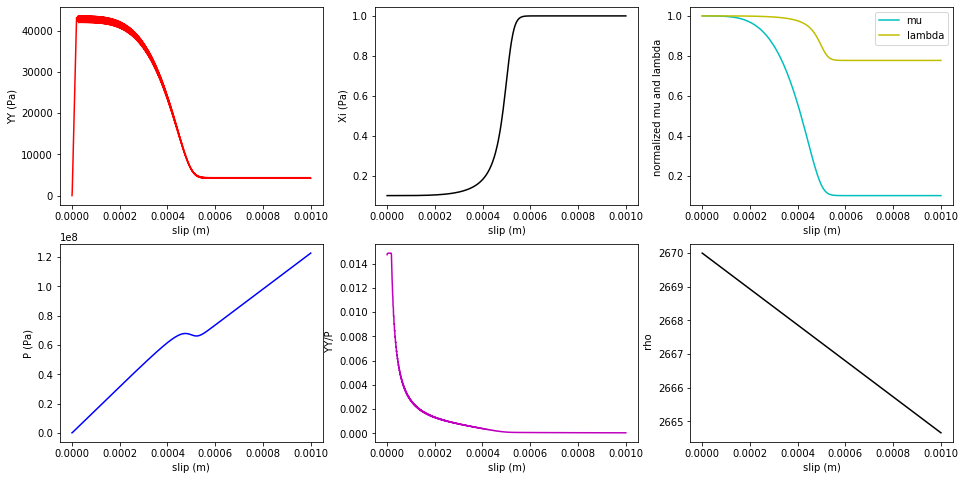

In [143]:
# plot variables with slip distance (m)
fig,ax = plt.subplots(ncols=3,nrows=2,figsize=(16,8));

#ax[0,0].set_title('Second invariant stress (Pa)');
ax[0,0].set_xlabel('slip (m)');
ax[0,0].set_ylabel('YY (Pa)');
ax[0,0].plot(slp,YY,'-r');

#ax[0,0].plot(np.array([slp[200],slp[200]]),np.array([np.max(YY),np.min(YY)]),'-.k');
#ax[0,0].plot(np.array([slp[400],slp[400]]),np.array([np.max(YY),np.min(YY)]),'-.k');

#ax[0,1].set_title('damage coeff.)');
ax[0,1].set_xlabel('slip (m)');
ax[0,1].set_ylabel('Xi (Pa)');
ax[0,1].plot(slp,c,'-k');


#ax[0,2].set_title('plastic slip rate');
ax[0,2].set_xlabel('slip (m)');
ax[0,2].set_ylabel('normalized mu and lambda ');
# ax[0,2].plot(slp[1:],vp[1:],'-c');
ax[0,2].plot(slp,M/np.max(M),'-c');
ax[0,2].plot(slp,L/np.max(L),'-y');
# ax[0,2].plot(slp[1:],tauM[1:]/np.max(tauM[1:]),'-b');

ax[0,2].legend(['mu','lambda','tau']);


#ax[1,0].set_title('hydrostatic stress (Pa)');
ax[1,0].set_xlabel('slip (m)');
ax[1,0].set_ylabel('P (Pa)');
ax[1,0].plot(slp,P,'-b');

#ax[1,1].set_title('equivalent friction coeff (YY/P)');
ax[1,1].set_xlabel('slip (m)');
ax[1,1].set_ylabel(' YY/P');
ax[1,1].plot(slp,YY/P,'-m');

#ax[1,1].set_title('Sxx');
ax[1,2].set_xlabel('slip (m)');
ax[1,2].set_ylabel(' rho');
ax[1,2].plot(slp[1:],rho[1:],'-k');